# Task 2: providing an illustrative example that provides a graphical representation of the method. You can create a synthetic data set and show importance scores like the one in the conference paper. 

In [155]:
m =6
alpha = 0.5

In [156]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from numpy import linalg as la
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from dppy.finite_dpps import FiniteDPP
import seaborn as sns
import scipy.io as sio
import time
import matplotlib.pyplot as plt 


# To plot consistent and pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 120


# Landmark selection techniques 
def landmark_uniform(X, m):
    '''Uniform landmark selection'''
    n = len(X)
    ind = np.random.choice(n, m, replace=False)
    return X[ind]    

def landmark_kmeans(X,m):
    '''K-means landmark selection'''
    return KMeans(n_clusters=m, max_iter=100).fit(X).cluster_centers_

def landmark_dpp(K_org,X,max_eig,m):
    '''DPP landmark selection'''
    DPP = FiniteDPP(kernel_type='correlation',
                projection=False,
                **{'K': K_org/max_eig})
    try:
        ind = DPP.sample_mcmc_k_dpp(size=m)
        return X[ind] 
    except: 
        return np.ones((m,X.shape[1]))

def landmark_importanceSampling(X,sigma,m,frac,alpha):
    '''Proposed importance sampling landmark selection
       Coarse-to-fine landmark selection strategy:
       m/2: uniform 
       m/2: based on the importance sampling distribution
    '''
    n = len(X)
    n_important = np.int(np.floor(frac*n))
    
    # n0: uniform, n1: K-means
    n0, n1 = np.int(np.floor(m/2)), np.int(np.ceil(m/2))
    
    # uniform 
    ind0 = np.random.choice(n, n0, replace=False)
    Z1 = X[ind0]
    
    # K-means 
    ind_remain = np.delete(np.arange(n), ind0)
    X_sub = X[ind_remain] # now, we work with the subsampled data set
    Dist = euclidean_distances(X_sub,Z1, squared=False) / sigma
    DistMin = Dist.min(axis=1)
    Prob = (1-alpha)/len(ind_remain) + alpha*(DistMin/np.sum(DistMin))
    ind1 = np.random.choice(len(X_sub), size=n_important, replace=False, p=Prob)
    Z2 = KMeans(n_clusters=n1, max_iter=100).fit(X_sub[ind1]).cluster_centers_
    
    # concatenate
    Z = np.concatenate((Z1,Z2),axis=0) 
    
    return Z 

def nystrom(X,Z,sigma,r):
    '''Computing low-rank approximation using the Nystrom method'''
    C = np.exp(-euclidean_distances(X,Z,squared=True)/(sigma**2))
    W = np.exp(-euclidean_distances(Z,squared=True)/(sigma**2))
    W = (W + W.T)/2
    Q, R = la.qr(C, mode='reduced')
    V, Sigma, _ = la.svd(la.multi_dot([R, np.linalg.pinv(W), np.transpose(R)]))
    EigVecNys = np.matmul(Q, V[:,:r])
    EigValNys = Sigma[:r]
    return EigVecNys, EigValNys


In [157]:
# To plot consistent and pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 120

size of input data and target:  (2000, 2) (2000,)


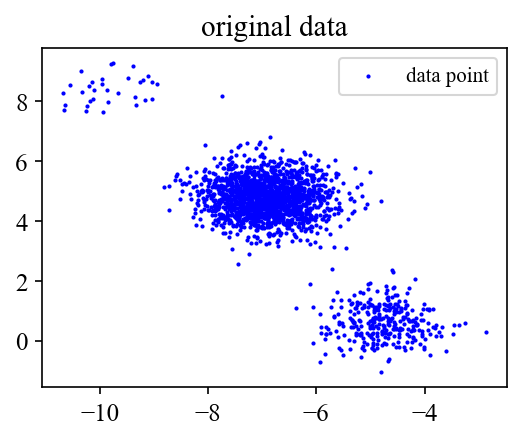

In [158]:
# Imbalanced data (here, we can use any other dataset --> X, y)
# Fig 1.1 Input dataset


n_samples = 5000
random_state = 12
X, y = make_blobs(n_samples=n_samples, cluster_std=0.6, random_state=random_state)

X_imb = np.concatenate ( [X[y==0], X[y==1][:300], X[y==2][:33]], axis=0)
y_imb = np.concatenate( (np.zeros(np.sum(y==0)), np.ones(300), 2*np.ones(33)) )

plt.figure(num=None, figsize=(4, 3), dpi=150,facecolor='w')
plt.scatter(X_imb[:, 0], X_imb[:, 1], s=1, c='b',label = "data point")
plt.title("original data", fontsize=14)
plt.legend(loc="best")
plt.savefig('Fig 1.1.png')
X = X_imb
y = y_imb
print("size of input data and target: ", X.shape, y.shape)



In [52]:
def landmark_uniform(X, m):
    '''Uniform landmark selection'''
    n = len(X)
    ind = np.random.choice(n, m, replace=False)
    return X[ind]

In [15]:
ZUniform=landmark_uniform(X, 3)

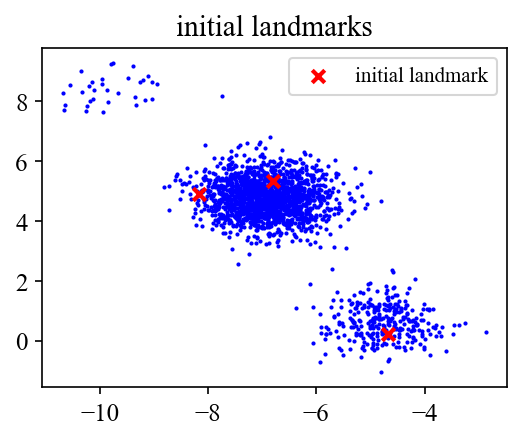

In [159]:
# Fig 1.2 Initial landmarks
plt.figure(num=None, figsize=(4, 3), dpi=150,facecolor='w')
plt.scatter(X[:, 0], X[:, 1], s=1, c='b')
plt.scatter(ZUniform[:,0], ZUniform[:,1], marker="x", color='r',label = "initial landmark")
plt.title("initial landmarks", fontsize=14)
plt.legend(loc="best")
plt.savefig('Fig 1.2.png')
plt.show()

In [160]:
beta = 0.9
DistMatrix = euclidean_distances(X, squared=True) 
sigma = beta * np.sqrt( np.sum(DistMatrix, axis=(0,1))/(len(DistMatrix)**2 - len(DistMatrix)) )


def landmark_importanceSampling(X,sigma,m,frac,alpha):
    '''Proposed importance sampling landmark selection
       Coarse-to-fine landmark selection strategy:
       m/2: uniform 
       m/2: based on the importance sampling distribution
    '''
    n = len(X)
    n_important = np.int(np.floor(frac*n))
    
    # n0: uniform, n1: K-means
    n0, n1 = np.int(np.floor(m/2)), np.int(np.ceil(m/2))
    
    # uniform 
    ind0 = np.random.choice(n, n0, replace=False)
    Z1 = X[ind0]
    
    # K-means 
    ind_remain = np.delete(np.arange(n), ind0)
    X_sub = X[ind_remain] # now, we work with the subsampled data set
    Dist = euclidean_distances(X_sub,Z1, squared=False) / sigma
    DistMin = Dist.min(axis=1)
    Prob = (1-alpha)/len(ind_remain) + alpha*(DistMin/np.sum(DistMin))
    ind1 = np.random.choice(len(X_sub), size=n_important, replace=False, p=Prob)
    Z2 = KMeans(n_clusters=n1, max_iter=100).fit(X_sub[ind1]).cluster_centers_
    
    # concatenate
    Z = np.concatenate((Z1,Z2),axis=0) 
    
    return Prob 


In [161]:
Prob= landmark_importanceSampling(X,sigma,m = 6,frac=0.1, alpha=0.5)

In [162]:
Prob.shape

(1997,)

In [163]:
import matplotlib
matplotlib.axes.Axes.contour
matplotlib.pyplot.contour
matplotlib.axes.Axes.contourf
matplotlib.pyplot.contourf
matplotlib.figure.Figure.colorbar
matplotlib.pyplot.colorbar
matplotlib.axes.Axes.legend
matplotlib.pyplot.legend
matplotlib.contour.ContourSet
matplotlib.contour.ContourSet.legend_elements

<function matplotlib.contour.ContourSet.legend_elements(self, variable_name='x', str_format=<class 'str'>)>

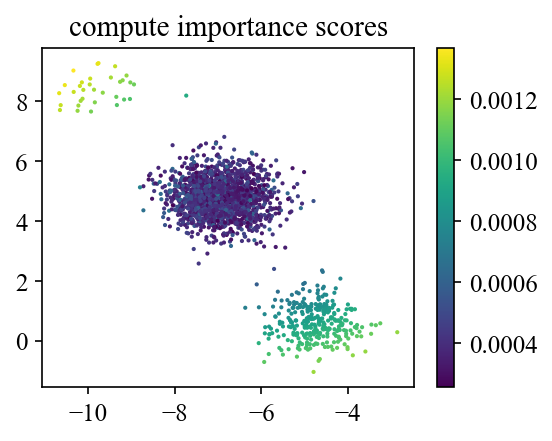

In [179]:
# Fig 1.3 :  compute importance scores
ind0 = np.random.choice(2000, 3, replace=False)
ind_remain = np.delete(np.arange(2000), ind0)
X_sub = X[ind_remain]
# ax = plt.axes()
plt.figure(num=None, figsize=(4, 3), dpi=150,facecolor='w')

c= plt.scatter(X_sub[:, 0], X_sub[:, 1], s = 1,  c = Prob)
plt.xticks([-10,-8,-6,-4])
plt.title("compute importance scores",fontsize=14)
cb = plt.colorbar(c)
# matplotlib.colorbar.Colorbar.set_ticklabels(ticklabels)
# cb.set_ticks(['Low', 'Medium', 'High'])
# cb.ax.set_xticklabels(['Low', 'Medium', 'High'])



plt.savefig('Fig 1.7.png')
plt.show()


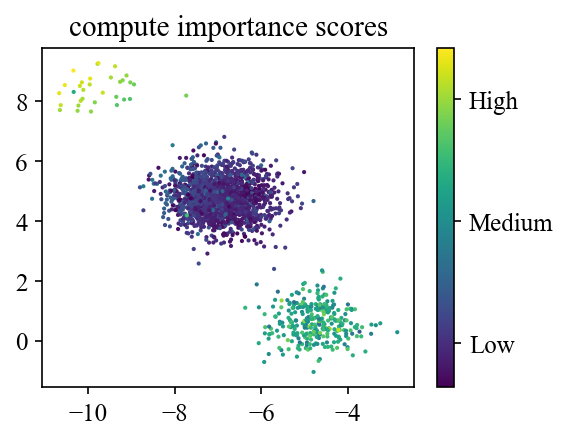

In [180]:
# Fig 1.3 :  compute importance scores
ind0 = np.random.choice(2000, 3, replace=False)
ind_remain = np.delete(np.arange(2000), ind0)
X_sub = X[ind_remain]
# ax = plt.axes()
plt.figure(num=None, figsize=(4, 3), dpi=150,facecolor='w')

c= plt.scatter(X_sub[:, 0], X_sub[:, 1], s = 1,  c = Prob)
plt.xticks([-10,-8,-6,-4])
plt.title("compute importance scores",fontsize=14)
cb = plt.colorbar(c,ticks=[0.0004, 0.0008, 0.0012], orientation='vertical')
cb.ax.set_yticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar



plt.savefig('Fig 1.8.png')
plt.show()

<Figure size 600x450 with 0 Axes>

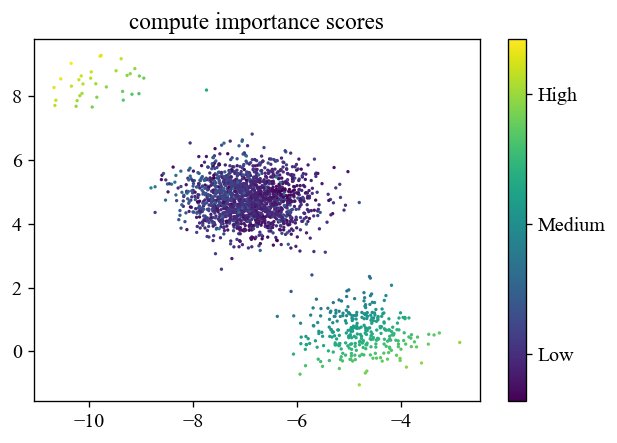

In [177]:
plt.figure(num=None, figsize=(4, 3), dpi=150,facecolor='w')
fig, ax = plt.subplots()
cax= plt.scatter(X_sub[:, 0], X_sub[:, 1], s = 1,  c = Prob)
plt.title("compute importance scores",fontsize=14)
# cax = ax.imshow(data, interpolation='nearest', cmap=cm.afmhot)
# ax.set_title('compute importance scores',fontsize=14)

cb = fig.colorbar(cax, ticks=[0.0004, 0.0008, 0.0012], orientation='vertical')
cb.ax.set_yticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar
plt.savefig('Fig 1.3.png')
plt.show()

In [59]:
def landmark_importanceSampling(X,sigma,m,frac,alpha):
    '''Proposed importance sampling landmark selection
       Coarse-to-fine landmark selection strategy:
       m/2: uniform 
       m/2: based on the importance sampling distribution
    '''
    n = len(X)
    n_important = np.int(np.floor(frac*n))
    
    # n0: uniform, n1: K-means
    n0, n1 = np.int(np.floor(m/2)), np.int(np.ceil(m/2))
    
    # uniform 
    ind0 = np.random.choice(n, n0, replace=False)
    Z1 = X[ind0]
    
    # K-means 
    ind_remain = np.delete(np.arange(n), ind0)
    X_sub = X[ind_remain] # now, we work with the subsampled data set
    Dist = euclidean_distances(X_sub,Z1, squared=False) / sigma
    DistMin = Dist.min(axis=1)
    Prob = (1-alpha)/len(ind_remain) + alpha*(DistMin/np.sum(DistMin))
    ind1 = np.random.choice(len(X_sub), size=n_important, replace=False, p=Prob)
    Z2 = KMeans(n_clusters=n1, max_iter=100).fit(X_sub[ind1]).cluster_centers_
    
    # concatenate
    Z = np.concatenate((Z1,Z2),axis=0) 
    
    return Z2

In [37]:
Z2 = landmark_importanceSampling(X,sigma,m = 6,frac=0.1, alpha=0.5)

In [38]:
Z2

array([[ -4.71832217,   0.44682194],
       [ -6.9566223 ,   4.81286868],
       [-10.06856677,   8.37410942]])

In [28]:
def landmark_importanceSampling(X,sigma,m,frac,alpha):
    '''Proposed importance sampling landmark selection
       Coarse-to-fine landmark selection strategy:
       m/2: uniform 
       m/2: based on the importance sampling distribution
    '''
    n = len(X)
    n_important = np.int(np.floor(frac*n))
    
    # n0: uniform, n1: K-means
    n0, n1 = np.int(np.floor(m/2)), np.int(np.ceil(m/2))
    
    # uniform 
    ind0 = np.random.choice(n, n0, replace=False)
    Z1 = X[ind0]
    
    # K-means 
    ind_remain = np.delete(np.arange(n), ind0)
    X_sub = X[ind_remain] # now, we work with the subsampled data set
    Dist = euclidean_distances(X_sub,Z1, squared=False) / sigma
    DistMin = Dist.min(axis=1)
    Prob = (1-alpha)/len(ind_remain) + alpha*(DistMin/np.sum(DistMin))
    ind1 = np.random.choice(len(X_sub), size=n_important, replace=False, p=Prob)
    Z2 = KMeans(n_clusters=n1, max_iter=100).fit(X_sub[ind1]).cluster_centers_
    
    # concatenate
    Z = np.concatenate((Z1,Z2),axis=0) 
    
    return X_sub[ind1]

In [30]:
coreset = landmark_importanceSampling(X,sigma,m = 6,frac=0.1, alpha=0.5)

In [32]:
coreset.shape

(200, 2)

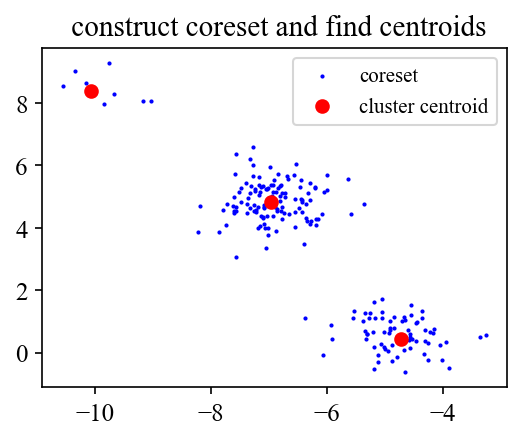

In [173]:
# Fig 1.4 : construct coreset and find centroids
plt.figure(num=None, figsize=(4, 3), dpi=150,facecolor='w')
plt.scatter(coreset[:, 0], coreset[:, 1], s = 1, color = 'b', label = "coreset")
plt.scatter(Z2[:,0], Z2[:,1], marker="o", color='r', label = "cluster centroid")
plt.title(" construct coreset and find centroids",fontsize=14)

plt.legend(loc="best")
plt.savefig('Fig 1.4.png')

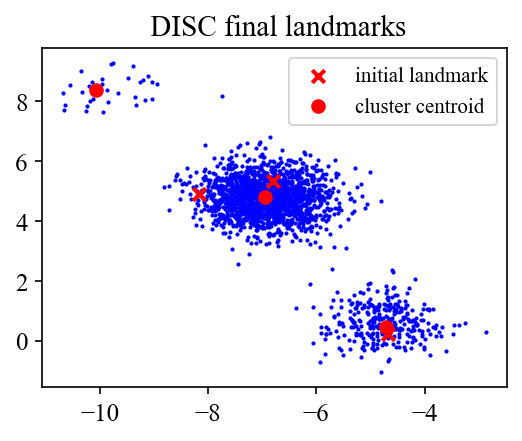

In [174]:
plt.figure(num=None, figsize=(4, 3), dpi=150,facecolor='w')
plt.scatter(X[:, 0], X[:, 1], s=1, c='b')
plt.scatter(ZUniform[:,0], ZUniform[:,1], marker="x", color='r', label = "initial landmark")
plt.scatter(Z2[:,0], Z2[:,1], marker="o", color='r', label = "cluster centroid")
plt.title(" DISC final landmarks",fontsize=14)
plt.legend(loc="best")
plt.savefig('Fig 1.5.png')
plt.show()

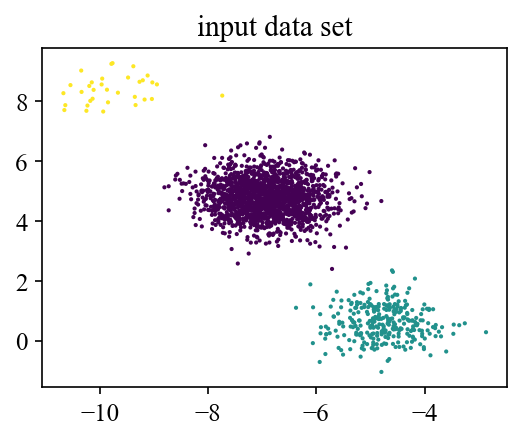

In [4]:
# Imbalanced data (here, we can use any other dataset --> X, y)
n_samples = 5000
random_state = 12
X, y = make_blobs(n_samples=n_samples, cluster_std=0.6, random_state=random_state)

X_imb = np.concatenate ( [X[y==0], X[y==1][:300], X[y==2][:33]], axis=0)
y_imb = np.concatenate( (np.zeros(np.sum(y==0)), np.ones(300), 2*np.ones(33)) )
# Fig 1.1
plt.figure(num=None, figsize=(4, 3), dpi=150,facecolor='w')
plt.scatter(X_imb[:, 0], X_imb[:, 1], s=1, c=y_imb)
plt.title("input data set", fontsize=14)
plt.savefig('Fig 1.1.png')
plt.show() 

In [ ]:
ind0 = np.random.choice(n, n0, replace=False)
Z1 = X[ind0]

In [ ]:
# Fig 1.3 : step 1: compute importance scores
plt.xlim([X[:, 0].min() - 1, X[:, 0].max() + 1])
plt.ylim([X[:, 1].min() - 1, X[:, 1].max() + 1])
Distributionprobability = list(Distributionprobability)
c= plt.scatter(X[:, 0], X[:, 1], s = 1,  c = Distributionprobability )
plt.title("step 1: compute importance scores")

plt.colorbar(c)
plt.show()

In [ ]:
# Fig 1.4 :step 2: construct coreset and find centroids
plt.xlim([Coreset[:, 0].min() - 1, Coreset[:, 0].max() + 1])
plt.ylim([Coreset[:, 1].min() - 1, Coreset[:, 1].max() + 1])
plt.scatter(Coreset[:, 0], Coreset[:, 1], s = 1, color = 'b', label = "coreset") 
plt.title("step 2: construct coreset and find centroids") 
kmeans = KMeans(n_clusters = 6, n_init = 1,max_iter = 20, random_state = 0)
kmeans = kmeans.fit(Coreset)
ZImportance = np.array(kmeans.cluster_centers_)
plt.scatter(ZImportance[:,0], ZImportance[:,1], marker=".", color='r', label = "landmark")
plt.legend(loc="best")
plt.show()
